# Introduction to matrix multiplication

BrainScaleS-2 is capable of performing multiply-accumulate (MAC)
operations within the analog network core. To multiply a vector with a
matrix, the matrix is configured as synapse weights. The vector is
encoded as pulse widths which stimulate synapse rows, therefore each
synapse multiplies its weight with a vector entry. Neurons accumulate
synaptic inputs from their column, thus accumulate the multiplication
results from a matrix column.

## Example

First, we demonstrate how a neuron responds to synaptic currents in
integration mode.

By altering the target parameters for calibration, we set the neurons to
short synaptic time constants and long membrane time constants. When
observing the membrane at the typical time ranges of many milliseconds
biological time, we can observe step-like changes in the membrane
potential for each synaptic stimulus. Since vector-matrix multiplication
has no continuous time, we can send the vector entries much faster than
biological spikes, at up to 125 MHz (hardware time, biological
equivalent: 125 kHz).

In this example, we generate a few inputs and observe the neuron
membrane during integration.

In order to use the microscheduler we have to set some environment variables first:

In [14]:
from _static.common.helpers import setup_hardware_client
setup_hardware_client()

INFO  00:28:52,766  demo_helpers Connection to hxcube7fpga0chip57_1 established


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

import pynn_brainscales.brainscales2 as pynn
from pynn_brainscales.brainscales2 import Population
from pynn_brainscales.brainscales2.standardmodels.cells import SpikeSourceArray
from pynn_brainscales.brainscales2.standardmodels.synapses import StaticSynapse


def plot_membrane_dynamics(population: Population, segment_id=-1, ylim=None):
    """
    Plot the membrane potential of the neuron in a given population view. Only
    population views of size 1 are supported.
    :param population: Population, membrane traces and spikes are plotted for.
    :param segment_id: Index of the neo segment to be plotted. Defaults to
                       -1, encoding the last recorded segment.
    :param ylim: y-axis limits for the plot.
    """
    if len(population) != 1:
        raise ValueError("Plotting is supported for populations of size 1.")
    # Experimental results are given in the 'neo' data format
    mem_v = population.get_data("v").segments[segment_id].irregularlysampledsignals[0]

    plt.plot(mem_v.times, mem_v, alpha=0.5)
    print(f"Mean membrane potential: {np.mean(np.array(mem_v.base))}")
    plt.xlabel("Wall clock time [ms]")
    plt.ylabel("ADC readout [a.u.]")
    if ylim:
        plt.ylim(ylim)

Next we load a nightly calibration which is specifically tuned for the integration of synaptic inputs, for example it targets long membrane time constants.
We save this calibration in two variables and use it later to define our neural network:

In [16]:
from _static.common.helpers import get_nightly_calibration
calib = get_nightly_calibration("hagen_cocolist.pbin")

Now we define our experiment:

Mean membrane potential: 395.3419494628906


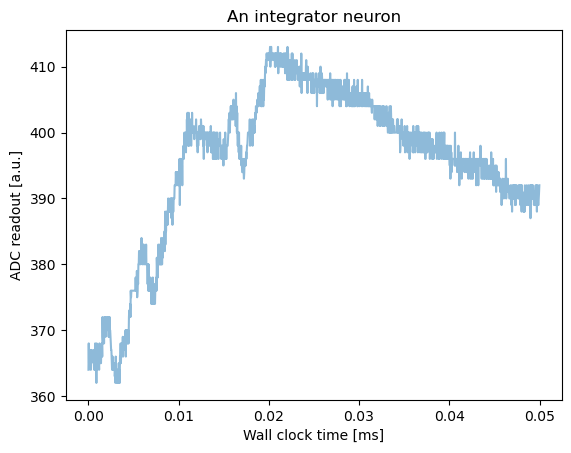

In [17]:
def generate_external_inputs(stimulated_population):
    """
    Create off-chip populations serving as excitatory/inhibitory spike sources.

    Feel free to modify the `{exc,inh}_spiketimes` and the `weight` of the stimulation.

    :param simulated_population: Population to map inputs to.
    """
    exc_spiketimes = [1, 3, 4, 5, 7, 8, 9, 10, 15, 17, 18, 19]  # us
    exc_spiketimes = np.array(exc_spiketimes) / 1e3
    exc_stim_pop = pynn.Population(1, SpikeSourceArray(spike_times=exc_spiketimes))
    pynn.Projection(exc_stim_pop, stimulated_p,
                    pynn.AllToAllConnector(),
                    synapse_type=StaticSynapse(weight=63),
                    receptor_type="excitatory")

    inh_spiketimes = [2, 6, 16]  # us (bio: ms)
    inh_spiketimes = np.array(inh_spiketimes) / 1e3
    inh_stim_pop = pynn.Population(1, SpikeSourceArray(spike_times=inh_spiketimes))
    pynn.Projection(inh_stim_pop, stimulated_p,
                    pynn.AllToAllConnector(),
                    synapse_type=StaticSynapse(weight=-63),
                    receptor_type="inhibitory")

plt.figure()
plt.title("An integrator neuron")

# reset membrane potential before beginning of experiment (it floats otherwise)
pynn.setup(initial_config=calib)

# use calibrated parameters for neuron
silent_p = pynn.Population(2, pynn.cells.HXNeuron())
stimulated_p = pynn.Population(1, pynn.cells.HXNeuron())
generate_external_inputs(stimulated_p)
stimulated_p.record(["v", "spikes"])

pynn.run(50e-3)  # run for 50 us
plot_membrane_dynamics(stimulated_p)
plt.show()

In the plot, you can see the integration phase in the beginning and a
random drift after all inputs are received. Since the leakage is
disabled, we do not decay to a controlled leak potential.

For practial usage, the vector entries will be sent much faster, at a
rate of up to 125 MHz, so the membrane has much less time to drift than
here. In the beginning, the membrane potential is reset to a known
starting voltage and in the end, the potential is digitized immediately
after all inputs are received.

We will now use the `hxtorch` software frontend which provides a
vector-matrix multiplication on chip and supports the standard layers
used in deep neural networks. First, we investigate the characteristics
of the analog MAC operation.

## 1. Equal spike counts, opposite weights
Spike counts: 5 excitatory and 5 inhibitory

Weights: +63 (excitatory), -63 (inhibitory)

Expected outcome: Total effect should cancel out

Mean membrane potential: 306.7267150878906


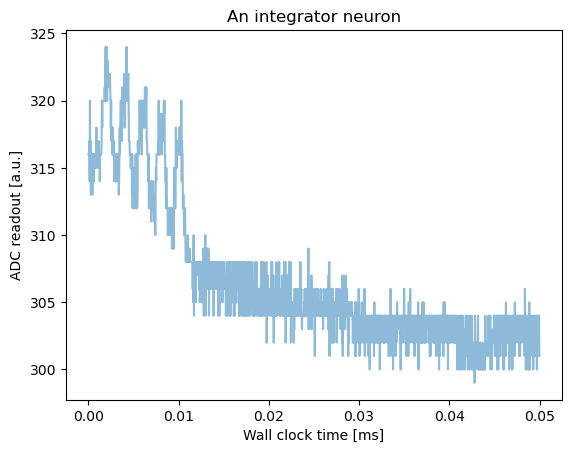

In [25]:
def generate_external_inputs(stimulated_population):
    """
    Create off-chip populations serving as excitatory/inhibitory spike sources.

    Feel free to modify the `{exc,inh}_spiketimes` and the `weight` of the stimulation.

    :param simulated_population: Population to map inputs to.
    """
    exc_spiketimes = [1, 3, 5, 7, 9]  # us
    exc_spiketimes = np.array(exc_spiketimes) / 1e3
    exc_stim_pop = pynn.Population(1, SpikeSourceArray(spike_times=exc_spiketimes))
    pynn.Projection(exc_stim_pop, stimulated_p,
                    pynn.AllToAllConnector(),
                    synapse_type=StaticSynapse(weight=63),
                    receptor_type="excitatory")

    inh_spiketimes = [2, 4, 6, 8, 10]  # us (bio: ms)
    inh_spiketimes = np.array(inh_spiketimes) / 1e3
    inh_stim_pop = pynn.Population(1, SpikeSourceArray(spike_times=inh_spiketimes))
    pynn.Projection(inh_stim_pop, stimulated_p,
                    pynn.AllToAllConnector(),
                    synapse_type=StaticSynapse(weight=-63),
                    receptor_type="inhibitory")

plt.figure()
plt.title("An integrator neuron")

# reset membrane potential before beginning of experiment (it floats otherwise)
pynn.setup(initial_config=calib)

# use calibrated parameters for neuron
silent_p = pynn.Population(2, pynn.cells.HXNeuron())
stimulated_p = pynn.Population(1, pynn.cells.HXNeuron())
generate_external_inputs(stimulated_p)
stimulated_p.record(["v", "spikes"])

pynn.run(50e-3)  # run for 50 us
plot_membrane_dynamics(stimulated_p)
plt.show()

I tested this setup to see if balanced excitatory and inhibitory input would truly neutralize each other at the neuron. As expected, the plot shows the membrane voltage initially rises with the excitatory spikes, but then drops back down due to the inhibitory ones. The final voltage stabilizes close to the starting value, confirming that the inputs effectively cancel out.

This was a useful configuration to verify whether the system correctly integrates and balances inputs of equal strength but opposite sign.



## 2. Gradual step buildup
Spike times: evenly spaced (like [1, 2, 3, 4])

All excitatory spikes

All same weight

Good for showing staircase voltage trace



Mean membrane potential: 389.4568176269531


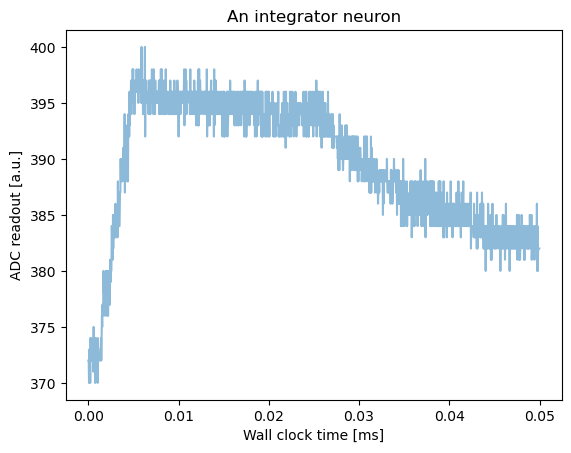

In [38]:
def generate_external_inputs(stimulated_population):
    """
    Create off-chip populations serving as excitatory/inhibitory spike sources.

    Feel free to modify the `{exc,inh}_spiketimes` and the `weight` of the stimulation.

    :param simulated_population: Population to map inputs to.
    """
    exc_spiketimes = [1, 2, 3, 4]  # us
    exc_spiketimes = np.array(exc_spiketimes) / 1e3
    exc_stim_pop = pynn.Population(1, SpikeSourceArray(spike_times=exc_spiketimes))
    pynn.Projection(exc_stim_pop, stimulated_p,
                    pynn.AllToAllConnector(),
                    synapse_type=StaticSynapse(weight=63),
                    receptor_type="excitatory")


plt.figure()
plt.title("An integrator neuron")

# reset membrane potential before beginning of experiment (it floats otherwise)
pynn.setup(initial_config=calib)

# use calibrated parameters for neuron
silent_p = pynn.Population(2, pynn.cells.HXNeuron())
stimulated_p = pynn.Population(1, pynn.cells.HXNeuron())
generate_external_inputs(stimulated_p)
stimulated_p.record(["v", "spikes"])

pynn.run(50e-3)  # run for 50 us
plot_membrane_dynamics(stimulated_p)
plt.show()

This configuration was meant to visualize how the neuron integrates input step-by-step. With evenly spaced excitatory spikes and equal weights, the membrane voltage rises gradually in discrete steps. The resulting plot clearly shows this staircase pattern, making it a useful example to understand how the system accumulates inputs over time.

It’s a good sanity check that the integrator is behaving as expected, showing a clean voltage ramp with each incoming spike.